In [ ]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*
!pip install gym[classic_control]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 785 kB/994 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Ign:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.12
Err:1 http://security.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.12
  404  Not Found [IP: 185.125.190.39 80]
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/x/xorg-server/xvfb_1.19.6-1ubuntu4.12_amd64.deb  404  Not Found [IP: 185.125.190.39 80]
E: Unable to fetch s

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# change directory using the magic command %cd
### replace [MY PATH] below with your own path in Google Drive ###
%cd /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import cv2
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('MountainCar-v0', new_step_api=True, render_mode='single_rgb_array').unwrapped

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#DQN

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self, inFeatures, actionSize):
        super(DQN, self).__init__()
        self.lin1 = nn.Linear(inFeatures, 64)
        self.lin2 = nn.Linear(64,64)
        self.head = nn.Linear(64, actionSize)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.head(x)

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TARGET_UPDATE = 10
TAU = 0.001

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(2, n_actions).to(device)
target_net = DQN(2, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=0.0001, weight_decay=0.01, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training Durations')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.show()

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

0: Ep done; Duration : 1001
1: Ep done; Duration : 1001
2: Ep done; Duration : 1001
3: Ep done; Duration : 1001
4: Ep done; Duration : 1001
5: Ep done; Duration : 1001
6: Ep done; Duration : 1001
7: Ep done; Duration : 1001
8: Ep done; Duration : 1001
9: Ep done; Duration : 1001
10: Ep done; Duration : 1001
11: Ep done; Duration : 1001
12: Ep done; Duration : 1001
13: Ep done; Duration : 1001
14: Ep done; Duration : 1001
15: Ep done; Duration : 1001
16: Ep done; Duration : 1001
17: Ep done; Duration : 1001
18: Ep done; Duration : 1001
19: Ep done; Duration : 1001
20: Ep done; Duration : 1001
21: Ep done; Duration : 1001
22: Ep done; Duration : 1001
23: Ep done; Duration : 1001
24: Ep done; Duration : 1001
25: Ep done; Duration : 1001
26: Ep done; Duration : 1001
27: Ep done; Duration : 1001
28: Ep done; Duration : 1001
29: Ep done; Duration : 1001
30: Ep done; Duration : 1001
31: Ep done; Duration : 1001
32: Ep done; Duration : 1001
33: Ep done; Duration : 1001
34: Ep done; Duration : 

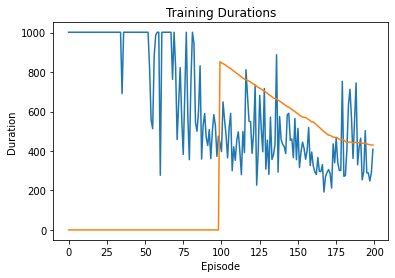

In [ ]:
num_episodes = 200
maxDuration = 0
best_net = DQN(2, n_actions).to(device)

i = 1
episode_durations = []

since = time.time()


for i_episode in range(num_episodes):
    env.reset()
    state,_,_,_,_ = env.step(env.action_space.sample())
    state = torch.tensor([state], device=device)

    for t in count():
        
        action = select_action(state)

        next_state, reward, done,_, info = env.step(action.item())
        
        reward = torch.tensor([reward], device=device)

        if done:
          next_state = None
        else:
          next_state = torch.tensor([next_state], device=device)

        memory.push(state, action, next_state, reward)

        state = next_state


        optimize_model()

        if (done or t > 1000):
            episode_durations.append(t + 1)
            break


        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for k in policy_net_state_dict:
            target_net_state_dict[k] = policy_net_state_dict[k]*TAU + target_net_state_dict[k]*(1-TAU)
        if t % TARGET_UPDATE == 0:
            torch.save(policy_net.state_dict(), '/content/drive/MyDrive/cartHillDiscretePolicy')
    print(f'{i_episode}: Ep done; Duration : {t}')



print('Complete')
dqnTime = time.time() - since
print(f'Cart Hill Discrete training time {dqnTime // 60:.0f}m {dqnTime % 60:.0f}s')
plot_durations()

In [ ]:
torch.save(policy_net.state_dict(), '/content/drive/MyDrive/cartHillDiscretePolicy')
torch.save(policy_net.state_dict(), 'currentPolicy')

In [ ]:
policy_net.load_state_dict(torch.load('/content/drive/MyDrive/cartHillDiscretePolicy'))

<All keys matched successfully>

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
testVideo = "testVideo.mp4"
video = VideoRecorder(env, testVideo)
duration = 0
env.reset()
state,_,_,_,_ = env.step(env.action_space.sample())
state = torch.tensor([state], device=device)
from base64 import b64encode
def render_mp4(videopath: str) -> str:

  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [ ]:
steps = 0
reallyDone = False
while True:
  env.render()
  video.capture_frame()

   # Select and perform an action
  action = select_action(state)
  next_state, reward, done,_, info = env.step(action.item())
  
  reward = torch.tensor([reward], device=device)
  # Observe new state

  next_state = torch.tensor([next_state], device=device)
  # Move to the next state
  state = next_state
  if(reallyDone or steps > 3000):
    break
  if(done):
    reallyDone = True
  steps += 1

video.close()

In [ ]:
from IPython.display import HTML
html = render_mp4(testVideo)
HTML(html)

#ACTOR CRITIC

In [ ]:
#This makes the actor network. It outputs a categorical distribution

from torch.distributions import Categorical
class Actor(nn.Module):
  def __init__(self, inputSize, outputSize):
    super(Actor, self).__init__()
    self.lin1 = nn.Linear(inputSize, 64)
    self.lin2 = nn.Linear(64,64)
    self.head = nn.Linear(64, outputSize)

  def forward(self, state):
    output = F.relu(self.lin1(state))
    output = F.relu(self.lin2(output))
    return Categorical(F.softmax(self.head(output), dim=-1))

In [ ]:
#This makes the critic network. It ouputs a value

class Critic(nn.Module):
  def __init__(self, inputSize):
    super(Critic, self).__init__()
    self.lin1 = nn.Linear(inputSize, 64)
    self.lin2 = nn.Linear(64,64)
    self.head = nn.Linear(64, 1)

  def forward(self, state):
    output = F.relu(self.lin1(state))
    output = F.relu(self.lin2(output))
    return self.head(output)

In [ ]:
n_actions = env.action_space.n
actor = Actor(2,n_actions).to(device)
critic = Critic(2).to(device)

actorOptimizer = optim.Adam(actor.parameters(), lr=0.000005, weight_decay=0.01, amsgrad=True)
criticOptimizer = optim.Adam(critic.parameters(), lr=0.00001, weight_decay=0.01, amsgrad=True)


def optimize(actorLoss, criticLoss):
  actorOptimizer.zero_grad()
  criticOptimizer.zero_grad()
  actorLoss.backward()
  criticLoss.backward()
  actorOptimizer.step()
  criticOptimizer.step()


0: Ep done; Duration: 501
1: Ep done; Duration: 501
2: Ep done; Duration: 501
3: Ep done; Duration: 501
4: Ep done; Duration: 501
5: Ep done; Duration: 501
6: Ep done; Duration: 501
7: Ep done; Duration: 501
8: Ep done; Duration: 501
9: Ep done; Duration: 501
10: Ep done; Duration: 501
11: Ep done; Duration: 501
12: Ep done; Duration: 501
13: Ep done; Duration: 501
14: Ep done; Duration: 501
15: Ep done; Duration: 501
16: Ep done; Duration: 501
17: Ep done; Duration: 501
18: Ep done; Duration: 501
19: Ep done; Duration: 501
20: Ep done; Duration: 501
21: Ep done; Duration: 501
22: Ep done; Duration: 501
23: Ep done; Duration: 501
24: Ep done; Duration: 501
25: Ep done; Duration: 501
26: Ep done; Duration: 501
27: Ep done; Duration: 501
28: Ep done; Duration: 501
29: Ep done; Duration: 501
30: Ep done; Duration: 501
31: Ep done; Duration: 501
32: Ep done; Duration: 501
33: Ep done; Duration: 501
34: Ep done; Duration: 501
35: Ep done; Duration: 501
36: Ep done; Duration: 501
37: Ep done

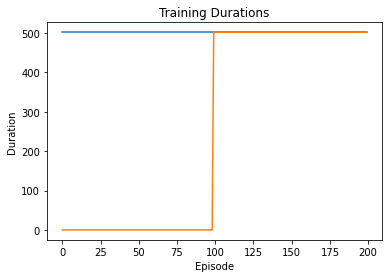

-502.0


In [ ]:
num_episodes = 200
DISCOUNT_FACTOR = 0.99
since = time.time()
scores = []
episode_durations = []

for iter in range(num_episodes):
  state = env.reset()
  state = torch.tensor([state], device=device)
  log_probs = []
  values = []
  rewards = []
  masks = []
  entropy = 0
  env.reset()
  score = 0
  I = 1
  for i in count():
    #Get outputs from the neural networks
    dist, currValue = actor(state), critic(state)
    action = dist.sample()

    next_state, reward, done,_, info = env.step(action.item())

    score += reward
    next_state = torch.tensor([next_state],device=device)
    nextValue = critic(next_state)

    if done:
      next_state = torch.tensor([0]).float().unsqueeze(0).to(device)
    #calculate the log probability of the policy distriution
    log_prob = dist.log_prob(action).unsqueeze(0)


    #Calculate the loss for the actor
    advantage = reward + DISCOUNT_FACTOR * nextValue.item()*(1-int(done)) - currValue.item()
    actor_loss = -log_prob * advantage
    actor_loss *= I
    
    #Calculate the loss for the critic
    critic_loss = F.mse_loss(reward+ DISCOUNT_FACTOR * nextValue, currValue)
    critic_loss *= I

    optimize(actor_loss, critic_loss)

    if (done or i > 500):
      episode_durations.append(i + 1)
      break
    state = next_state
    I *= DISCOUNT_FACTOR


  torch.save(actor.state_dict(), '/content/drive/MyDrive/cartHillActor')
  torch.save(critic.state_dict(), '/content/drive/MyDrive/cartHillCritic')
  print(f'{iter}: Ep done; Duration: {i}')
  scores.append(score)
actorCriticTime = time.time() - since
print(f'Actor Critic training time {actorCriticTime // 60:.0f}m {actorCriticTime % 60:.0f}s')
plot_durations()
print(score)

In [ ]:
torch.save(actor.state_dict(), 'actorNetwork')
torch.save(critic.state_dict(), 'criticNetwork')
torch.save(actor.state_dict(), '/content/drive/MyDrive/cartHillActor')
torch.save(critic.state_dict(), '/content/drive/MyDrive/cartHillCritic')

In [ ]:
actor.load_state_dict(torch.load('/content/drive/MyDrive/cartHillActor', map_location = torch.device('cpu')))
critic.load_state_dict(torch.load('/content/drive/MyDrive/cartHillCritic', map_location = torch.device('cpu')))

<All keys matched successfully>

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
testVideo = "testVideo.mp4"
video = VideoRecorder(env, testVideo)
duration = 0
state = env.reset()
state = torch.tensor([state],device = device)
from base64 import b64encode
def render_mp4(videopath: str) -> str:

  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [ ]:
reallyDone = False
steps = 0

while True:
  video.capture_frame()

  dist, value = actor(state), critic(state)

  action = dist.sample()
  next_state, reward, done,_, info = env.step(action.item())
  reward = torch.tensor([reward], device=device)
  next_state = torch.tensor([next_state], device=device)

  state = next_state
  steps += 1
  if(reallyDone):
    break
  if(done or steps > 1000):
    reallyDone = True

video.close()

/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:196: UserWarning: WARN: The video recorder has been closed and no frames will be captured anymore.
  logger.warn(


In [ ]:
from IPython.display import HTML
html = render_mp4(testVideo)
HTML(html)

#Evaluation

2986.78
1562.21
2979.24


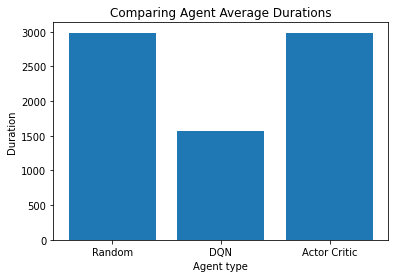

In [ ]:
randomTime = 0
dqnTime = 0
actorCriticTime = 0
for iterations in range(100):
  #Random
  state = env.reset()
  steps = 0
  while True:
    # Select and perform an action
    next_state, reward, done,_, info = env.step(env.action_space.sample())
    if(done or steps > 3000):
      break
    steps += 1
  randomTime += steps


  #DQN
  state = env.reset()
  state = torch.tensor([state], device=device)
  steps = 0
  while True:

    # Select and perform an action
    action = policy_net(state).max(1)[1].view(1, 1)
    next_state, reward, done,_, info = env.step(action.item())
    next_state = torch.tensor([next_state], device=device)
    # Move to the next state
    state = next_state
    if(done or steps > 3000):
      break
    steps += 1
  dqnTime += steps



  #Actor Critic
  state = env.reset()
  state = torch.tensor([state], device=device)
  steps = 0
  while True:

   # Select and perform an action
    dist, value = actor(state), critic(state)

    action = dist.sample()
    next_state, reward, done,_, info = env.step(action.item())
    next_state = torch.tensor([next_state], device=device)
    state = next_state
    if(done or steps > 3000):
      break
    steps += 1
  actorCriticTime += steps
print(randomTime/100)
print(dqnTime/100)
print(actorCriticTime/100)

agentName = ('Random', 'DQN', 'Actor Critic')
fig, ax = plt.subplots()
hbars = ax.bar(agentName, [(randomTime/100), (dqnTime/100), (actorCriticTime/100)])
ax.set_xlabel('Agent type')
ax.set_ylabel('Duration')
plt.title('Comparing Agent Average Durations')
plt.show()

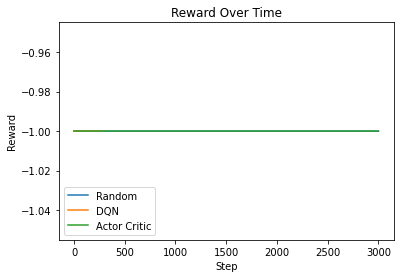

In [ ]:
randomReward = []
dqnReward = []
actorCriticReward = []

#Random
state = env.reset()
steps = 0
while True:
   # Select and perform an action
  next_state, reward, done,_, info = env.step(action.item())
  randomReward.append(reward)
  if(done or steps > 3000):
    break
  steps += 1

#DQN
state = env.reset()
state = torch.tensor([state], device=device)
steps = 0
while True:
   # Select and perform an action
  action = policy_net(state).max(1)[1].view(1, 1)
  next_state, reward, done,_, info = env.step(action.item())
  dqnReward.append(reward)
  reward = torch.tensor([reward], device=device)
  # Observe new state
  next_state = torch.tensor([next_state], device=device)
  # Move to the next state
  state = next_state
  if(done or steps > 3000):
    break
  steps += 1

#Actor Critic
state = env.reset()
state = torch.tensor([state], device=device)
steps = 0
while True:
  # Select and perform an action
  dist, value = actor(state), critic(state)
  action = dist.sample()
  next_state, reward, done,_, info = env.step(action.item())
  actorCriticReward.append(reward)
  reward = torch.tensor([reward], device=device)
  next_state = torch.tensor([next_state], device=device)

  state = next_state
  if(done or steps > 3000):
    break
  steps += 1



fig, ax = plt.subplots()
tRandom = range(len(randomReward))
tMid = range(len(dqnReward))
tLong = range(len(actorCriticReward))
ax.plot(tRandom, randomReward, label='Random')
ax.plot(tMid, dqnReward, label = 'DQN')
ax.plot(tLong, actorCriticReward, label = 'Actor Critic')
legend = ax.legend(loc='lower left')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward Over Time')
plt.show()